# SETUP

## Import Neccessary Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from re import A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Setting up the Data Frame

In [ ]:
# Load Excel file
#df = pd.read_excel("EmailSpamDataTrimmed.xlsx")
# Was initially using a trimmed xlsx file with features we selected by our own judgment, but had much better results using the full dataset.
df = pd.read_excel("emails.xlsm")

# print(df)

## Dropping Meaningless Columns and the Truth Column

In [ ]:
X = df.drop(columns=['Prediction', 'Email No.']) # all word count columns (features)
y = df['Prediction'] # the 'Prediction' column (labels: spam or legit)

# convert emails into numerical features (word frequency vectors)
x_vector = X.to_numpy()
y_vector = y.to_numpy()

print(x_vector)
print(y_vector)

[[ 0  0  1 ...  0  0  0]
 [ 8 13 24 ...  0  1  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  0]
 [ 2  7  1 ...  0  1  0]
 [22 24  5 ...  0  0  0]]
[0 0 0 ... 1 1 0]


## Split the Data for Training and Testing


In [ ]:
# split dataset
x_train, x_test, y_train, y_test = train_test_split(
    x_vector,
    y_vector,
    test_size=0.2,     # 20% test size
    random_state=42,   # makes the split reproducible
    stratify=y         # keeps the same spam/legit ratio in both sets
)

print("Train set size:", x_train.shape)
print("Test set size:", x_test.shape)

Train set size: (4137, 3000)
Test set size: (1035, 3000)


## Seeing How Many Features Should Be Used for PCA

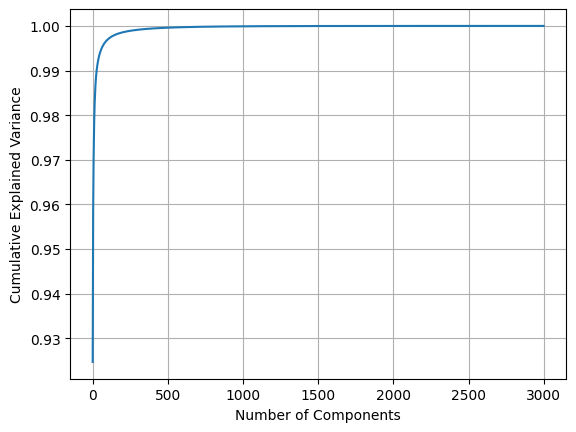

In [ ]:
from sklearn.decomposition import PCA
# removed duplicate plt import

pca = PCA().fit(x_train)  # X_train is your feature matrix
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


##**Setting up TruncatedSVD (WITH 65 COMPONENTS)**

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Apply TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components= 65, random_state=42)
# Retained variance of 1.00 with just 65 features!
x_train_svd = svd.fit_transform(x_train)
x_test_svd = svd.transform(x_test)
n_components = svd.n_components

# Print the explained variance ratio
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance retained with {n_components} components: {explained_variance:.2f}")

Explained variance retained with 65 components: 1.00


##**Setting up PCA (WITH 300 Components)**

In [ ]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=300)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

# Shift PCA-transformed data to make it non-negative
min_value = np.min(x_train_pca)  # Find the minimum value in the training data
x_train_pca_shifted = x_train_pca - min_value
x_test_pca_shifted = x_test_pca - min_value

# Verify the shift
print("Minimum value in shifted x_train_pca:", np.min(x_train_pca_shifted))
print("Minimum value in shifted x_test_pca:", np.min(x_test_pca_shifted))

Number of components selected: 300
Minimum value in shifted x_train_pca: 0.0
Minimum value in shifted x_test_pca: 366.18797329228215


# NAIVE BAYES MODEL

## Naives Bayes Model (PCA)

In [ ]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=300)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

# Shift PCA-transformed data to make it non-negative
min_value = np.min(x_train_pca)  # Find the minimum value in the training data
x_train_pca_shifted = x_train_pca - min_value
x_test_pca_shifted = x_test_pca - min_value

# Verify the shift
print("Minimum value in shifted x_train_pca:", np.min(x_train_pca_shifted))
print("Minimum value in shifted x_test_pca:", np.min(x_test_pca_shifted))

# Train Multinomial Naive Bayes with shifted PCA-transformed data
nb_model = MultinomialNB()
nb_model.fit(x_train_pca_shifted, y_train)

# Make predictions
y_pred = nb_model.predict(x_test_pca_shifted)

# Evaluate the model
print("Multinomial Naive Bayes Accuracy with PCA (Shifted):", accuracy_score(y_test, y_pred))
nbpca_accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

Number of components selected: 300
Minimum value in shifted x_train_pca: 0.0
Minimum value in shifted x_test_pca: 366.18797329227505
Multinomial Naive Bayes Accuracy with PCA (Shifted): 0.6396135265700483
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.76       735
           1       0.35      0.29      0.32       300

    accuracy                           0.64      1035
   macro avg       0.54      0.54      0.54      1035
weighted avg       0.62      0.64      0.63      1035



## Naive Bayes Model (TruncatedSVD)

In [ ]:
# Shift TruncatedSVD-transformed data to make it non-negative
min_value = np.min(x_train_svd)  # Find the minimum value in the training data
x_train_svd_shifted = x_train_svd - min_value
x_test_svd_shifted = x_test_svd - min_value

# Train Multinomial Naive Bayes with shifted TruncatedSVD-transformed data
nb_model = MultinomialNB()
nb_model.fit(x_train_svd_shifted, y_train)

# Make predictions
y_pred = nb_model.predict(x_test_svd_shifted)

# Evaluate the model
print("Multinomial Naive Bayes Accuracy with TruncatedSVD (Shifted):", accuracy_score(y_test, y_pred))
nbsvd_accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

Multinomial Naive Bayes Accuracy with TruncatedSVD (Shifted): 0.6415458937198067
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       735
           1       0.35      0.28      0.31       300

    accuracy                           0.64      1035
   macro avg       0.54      0.53      0.53      1035
weighted avg       0.62      0.64      0.63      1035



## Naive Bayes Model (All-Data)

In [ ]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(x_test)

# Evaluate the model
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred))
nb_accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

Naïve Bayes Accuracy: 0.9420289855072463
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       735
           1       0.87      0.94      0.90       300

    accuracy                           0.94      1035
   macro avg       0.92      0.94      0.93      1035
weighted avg       0.94      0.94      0.94      1035



## Naives Bayes Model Feature Importance

Top 10 Important Features for Naive Bayes:
        Feature  Importance
13        enron    8.074272
68        daren    6.768352
192        nbsp    6.712971
37          hpl    6.586540
58        mmbtu    6.432389
246       pills    6.287572
101      sitara    5.943310
110     volumes    5.881868
151  nomination    5.856827
341   computron    5.794485


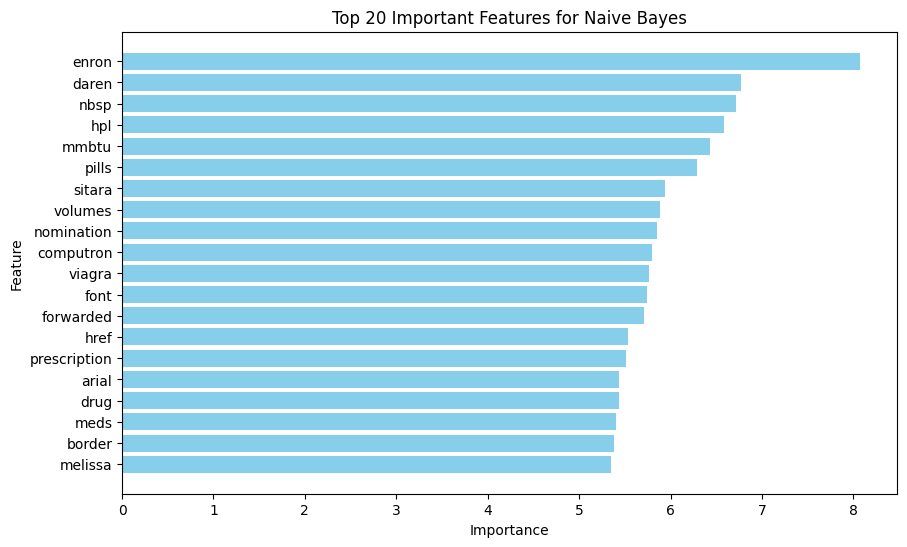

In [ ]:
# Access the log probabilities of features for each class
log_prob = nb_model.feature_log_prob_

# Calculate the difference in log probabilities between classes
# Assuming binary classification (spam vs. ham)
feature_importance = np.abs(log_prob[1] - log_prob[0])

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # Replace X.columns with the actual feature names
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print("Top 10 Important Features for Naive Bayes:")
print(feature_importance_df.head(10))

# Visualize the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features for Naive Bayes')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# **DECISION TREE MODEL**

## Decision Tree Model (All-Data)

In [ ]:
# Train Decision Tree with PCA-transformed data
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train_pca, y_train)

# Make predictions
y_pred_dt = dt_model.predict(x_test_pca)

# Evaluate the model
print("Decision Tree Accuracy with PCA:", accuracy_score(y_test, y_pred_dt))
dtpca_accuracy= accuracy_score(y_test, y_pred_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy with PCA: 0.8144927536231884
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       735
           1       0.69      0.66      0.67       300

    accuracy                           0.81      1035
   macro avg       0.78      0.77      0.77      1035
weighted avg       0.81      0.81      0.81      1035



## Decision Tree Model (TruncatedSVD)

In [ ]:
# Train Decision Tree with TruncatedSVD-transformed data
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train_svd, y_train)

# Make predictions
y_pred_dt = dt_model.predict(x_test_svd)

# Evaluate the model
print("Decision Tree Accuracy with TruncatedSVD:", accuracy_score(y_test, y_pred_dt))
dtsvd_accuracy = accuracy_score(y_test, y_pred_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy with TruncatedSVD: 0.8154589371980676
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       735
           1       0.67      0.71      0.69       300

    accuracy                           0.82      1035
   macro avg       0.78      0.79      0.78      1035
weighted avg       0.82      0.82      0.82      1035



## Decision Tree Model (Non-PCA)

In [ ]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt_model.fit(x_train, y_train)

# Make predictions using the Decision Tree model
y_pred_dt = dt_model.predict(x_test)

# Evaluate the Decision Tree model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9188405797101449
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       735
           1       0.87      0.85      0.86       300

    accuracy                           0.92      1035
   macro avg       0.90      0.90      0.90      1035
weighted avg       0.92      0.92      0.92      1035



## Decision Tree Feature Importance (All-Data)

       Feature  Importance
13       enron    0.166351
916        ali    0.144556
92        http    0.094116
104        nom    0.061840
68       daren    0.048902
418      hanks    0.042205
36       meter    0.032330
81    attached    0.023332
95        mail    0.021757
17        will    0.015192
7          you    0.014236
37         hpl    0.013040
599      valid    0.012343
28          as    0.011624
1139      neon    0.011291
0          the    0.011220
101     sitara    0.011020
14           i    0.009948
1026    walker    0.008021
5           of    0.007918


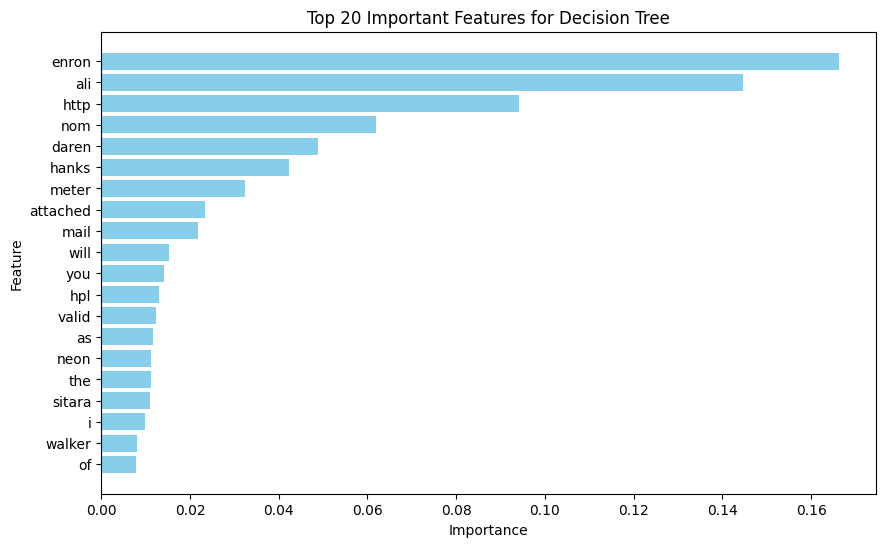

In [ ]:
# Assuming dt_model is your trained Decision Tree model
importance = dt_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df.head(20))
# Visualize the top 20 important features for the Decision Tree
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features for Decision Tree')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# **NEURAL NETWORK MODEL**

## Neural Network Setup

In [ ]:
# Define the neural network model
# Non linearity using relu.
# Last one for sigmoid to give a probability between 0 and 1.
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile( loss='binary_crossentropy', metrics=['accuracy'])

# Show the model's parameters
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,449 (1.50 MB)

 Trainable params: 392,449 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

## Neural Network (PCA)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6545 - loss: 2.3679 - val_accuracy: 0.8031 - val_loss: 0.5660
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7631 - loss: 0.8386 - val_accuracy: 0.5737 - val_loss: 2.1465
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7559 - loss: 0.9378 - val_accuracy: 0.8031 - val_loss: 0.5255
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7937 - loss: 0.6440 - val_accuracy: 0.7971 - val_loss: 0.7025
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7885 - loss: 0.6224 - val_accuracy: 0.8152 - val_loss: 0.4415
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7965 - loss: 0.5748 - val_accuracy: 0.6643 - val_loss: 0.7195
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7848 - loss: 0.5526 - val_accuracy: 0.8176 - val_loss: 0.4785
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7929 - loss: 0.5169 - val_accuracy: 0.7488 - val_

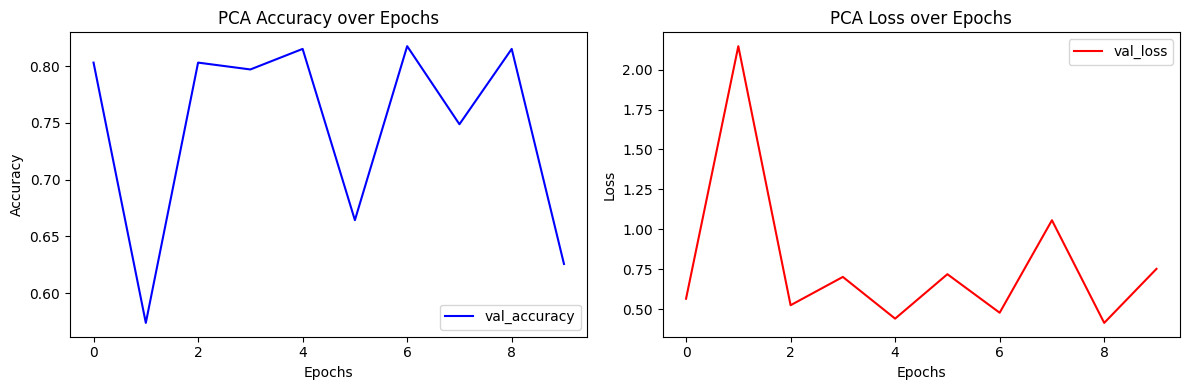

In [ ]:
# Define the neural network model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(x_train_pca.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions
y_pred_nn = model.predict(x_test_pca)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

# Evaluate the model
print("Neural Network Accuracy with PCA:", accuracy_score(y_test, y_pred_nn))
nnpca_accuracy = accuracy_score(y_test, y_pred_nn)
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

# Plot validation accuracy and loss from history
def plot_results(history):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

    # Plot accuracy
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy', color='b')
    ax[0].set_title('PCA Accuracy over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')

    # Plot loss
    ax[1].plot(history.history['val_loss'], label='val_loss', color='r')
    ax[1].set_title('PCA Loss over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')

    plt.tight_layout()  # Prevents overlap of titles and labels
    plt.show()

# Call the function
plot_results(history)

## Neural Network (TruncatedSVD)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6894 - loss: 1.9031 - val_accuracy: 0.7488 - val_loss: 1.2785
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7612 - loss: 0.9526 - val_accuracy: 0.8043 - val_loss: 0.4764
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7952 - loss: 0.7363 - val_accuracy: 0.8188 - val_loss: 0.4353
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7713 - loss: 0.7127 - val_accuracy: 0.8140 - val_loss: 0.4169
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7962 - loss: 0.7156 - val_accuracy: 0.7669 - val_loss: 1.5297
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8146 - loss: 0.6812 - val_accuracy: 0.8043 - val_loss: 0.5381
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8072 - loss: 0.5879 - val_accuracy: 0.6377 - val_loss: 1.6129
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8112 - loss: 0.5999 - val_accuracy: 0.7729 - val_

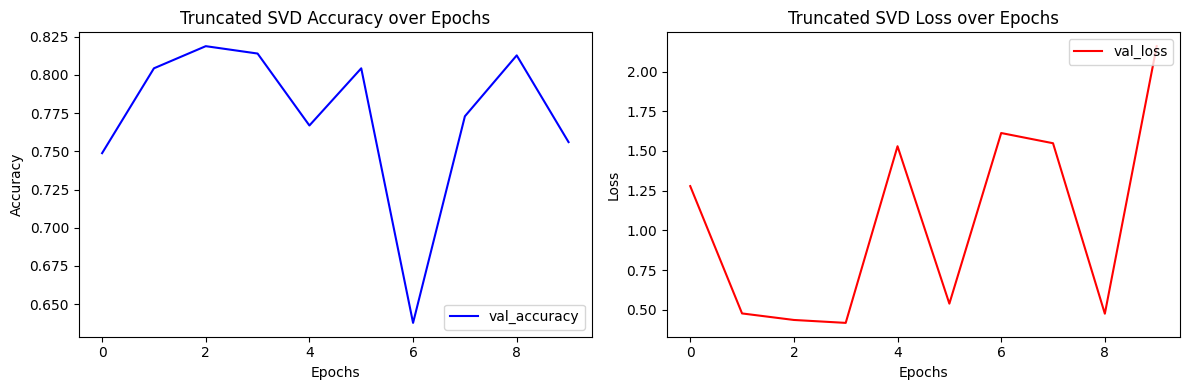

In [ ]:
# Define the neural network model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(x_train_svd.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_svd, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions
y_pred_nn = model.predict(x_test_svd)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

# Evaluate the model
print("Neural Network Accuracy with TruncatedSVD:", accuracy_score(y_test, y_pred_nn))
nnsvd_accuracy = accuracy_score(y_test, y_pred_nn)
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

# Plot validation accuracy and loss from history
def plot_results(history):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

    # Plot accuracy
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy', color='b')
    ax[0].set_title('Truncated SVD Accuracy over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')

    # Plot loss
    ax[1].plot(history.history['val_loss'], label='val_loss', color='r')
    ax[1].set_title('Truncated SVD Loss over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')

    plt.tight_layout()  # Prevents overlap of titles and labels
    plt.show()

# Call the function
plot_results(history)

## Nerual Network (All-Data)


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7720 - loss: 0.8523 - val_accuracy: 0.8261 - val_loss: 0.6482
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9089 - loss: 0.3469 - val_accuracy: 0.9698 - val_loss: 0.1466
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9679 - loss: 0.1342 - val_accuracy: 0.9710 - val_loss: 0.0873
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9763 - loss: 0.1068 - val_accuracy: 0.9783 - val_loss: 0.1192
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9705 - loss: 0.1463 - val_accuracy: 0.9746 - val_loss: 0.0730
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9890 - loss: 0.0816 - val_accuracy: 0.9746 - val_loss: 0.0837
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9896 - loss: 0.0697 - val_accuracy: 0.9650 - val_loss: 0.2537
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9927 - loss: 0.0485 - val_accuracy: 0

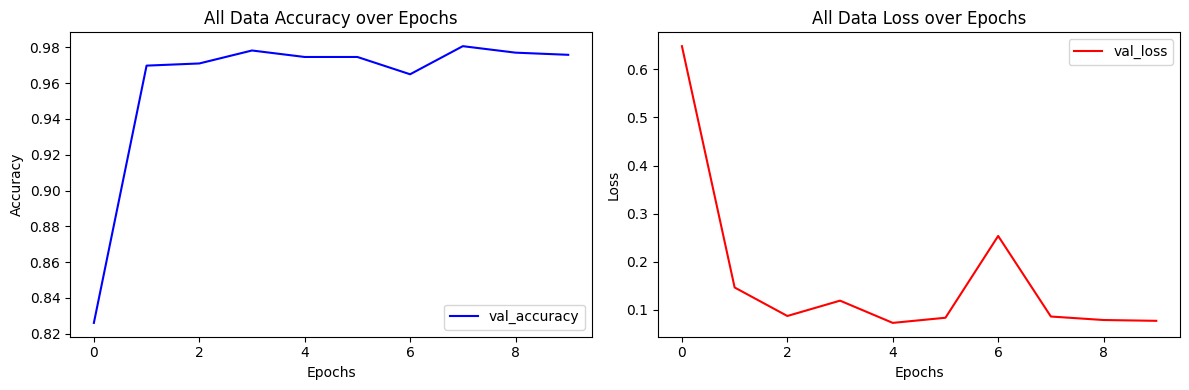

In [ ]:
# utilizing model with entire data as input
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compiling the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, save history
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_nn = model.predict(x_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
nn_accuracy = accuracy_score(y_test, y_pred_nn)
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

# Plot validation accuracy and loss from history
def plot_results(history):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

    # Plot accuracy
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy', color='b')
    ax[0].set_title('All Data Accuracy over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')

    # Plot loss
    ax[1].plot(history.history['val_loss'], label='val_loss', color='r')
    ax[1].set_title('All Data Loss over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')

    plt.tight_layout()  # Prevents overlap of titles and labels
    plt.show()

# Call the function
plot_results(history)

## Neural Network (Gradient Heat Map)

Top 10 Features for Neural Network (Gradient-Based):
       Feature  Importance
13       enron    0.013730
81    attached    0.013153
1139      neon    0.010784
68       daren    0.010703
1092       sex    0.010661
80      farmer    0.010533
242      money    0.010524
37         hpl    0.009932
1082      pain    0.009789
408        bob    0.009611


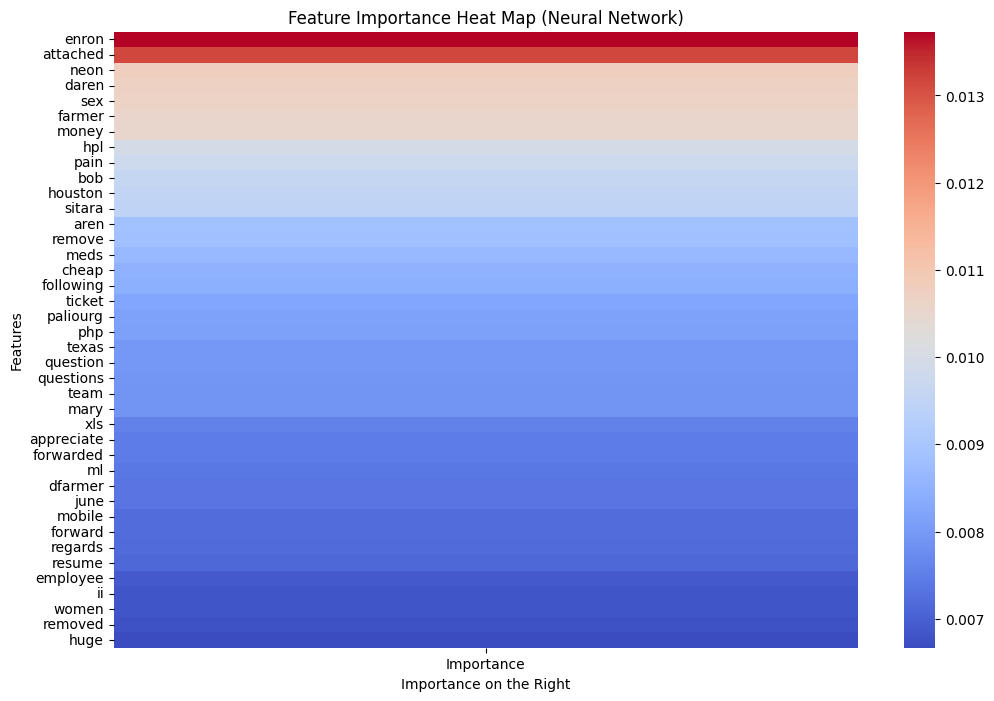

In [ ]:
import seaborn as sns

# Convert test data to a TensorFlow tensor
inputs = tf.convert_to_tensor(x_test, dtype=tf.float32)

# Use GradientTape to compute gradients
with tf.GradientTape() as tape:
    tape.watch(inputs)
    predictions = model(inputs)  # Get predictions from the model

# Compute gradients of predictions with respect to inputs
gradients = tape.gradient(predictions, inputs)

# Calculate the mean absolute gradient for each feature
feature_importance = np.mean(np.abs(gradients.numpy()), axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("Top 10 Features for Neural Network (Gradient-Based):")
print(feature_importance_df.head(10))

# Visualize top 40 data columns as a heat map
plt.figure(figsize=(12, 8))
sns.heatmap(
    feature_importance_df.set_index('Feature')[:40],  # Transpose for better visualization
    cmap='coolwarm',
    annot=False,
    cbar=True
)
plt.title('Feature Importance Heat Map (Neural Network)')
plt.xlabel('Importance on the Right')
plt.ylabel('Features')
plt.show()

## Neural Network (Gradient Heat Map with ALL DATA)

Top 10 Features for Neural Network (Gradient-Based):
       Feature  Importance
13       enron    0.013730
81    attached    0.013153
1139      neon    0.010784
68       daren    0.010703
1092       sex    0.010661
80      farmer    0.010533
242      money    0.010524
37         hpl    0.009932
1082      pain    0.009789
408        bob    0.009611


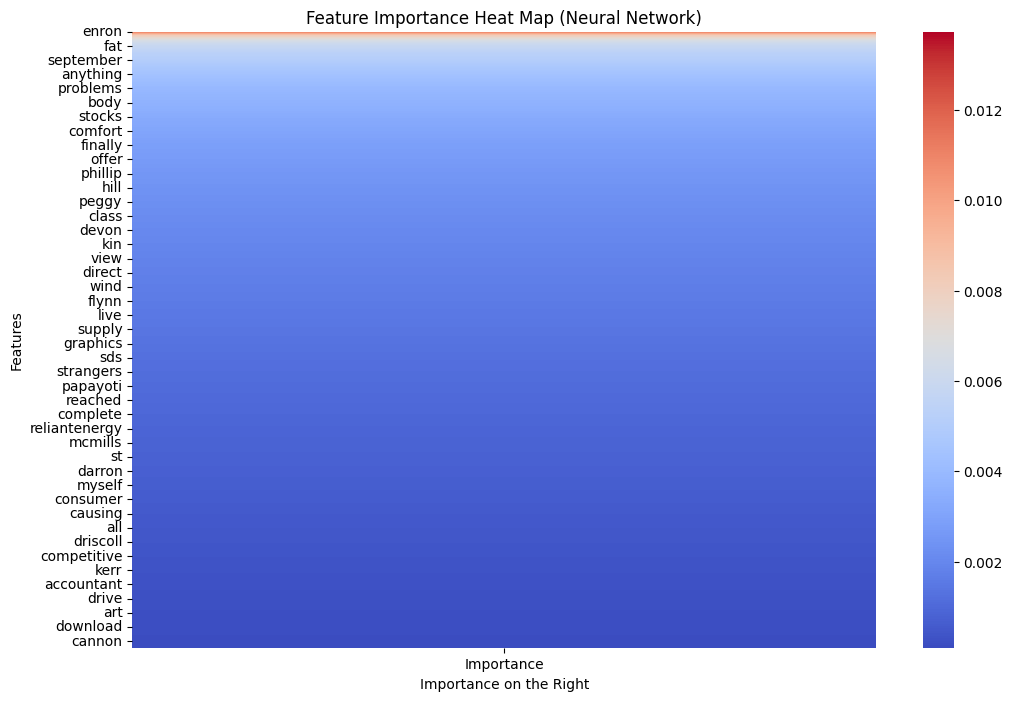

In [ ]:
# Display the top 10 features
print("Top 10 Features for Neural Network (Gradient-Based):")
print(feature_importance_df.head(10))

# Visualize as a heat map
plt.figure(figsize=(12, 8))
sns.heatmap(
    feature_importance_df.set_index('Feature'),  # Transpose for better visualization
    cmap='coolwarm',
    annot=False,
    cbar=True
)
plt.title('Feature Importance Heat Map (Neural Network)')
plt.xlabel('Importance on the Right')
plt.ylabel('Features')
plt.show()

# **XG BOOST MODEL**

## XG Boost Model (ALLDATA)

In [ ]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost model
xgb_model.fit(x_train, y_train)

# Make predictions using the XGBoost model
y_pred_xgb = xgb_model.predict(x_test)

# Evaluate the XGBoost model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9739130434782609
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       735
           1       0.94      0.97      0.96       300

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



## XG Boost Feature Importance

Top 10 Features for XGBoost:
        Feature  Importance
13        enron    0.069932
916         ali    0.061063
37          hpl    0.044069
68        daren    0.034076
104         nom    0.031313
151  nomination    0.028065
418       hanks    0.022587
36        meter    0.018706
92         http    0.017045
599       valid    0.016349


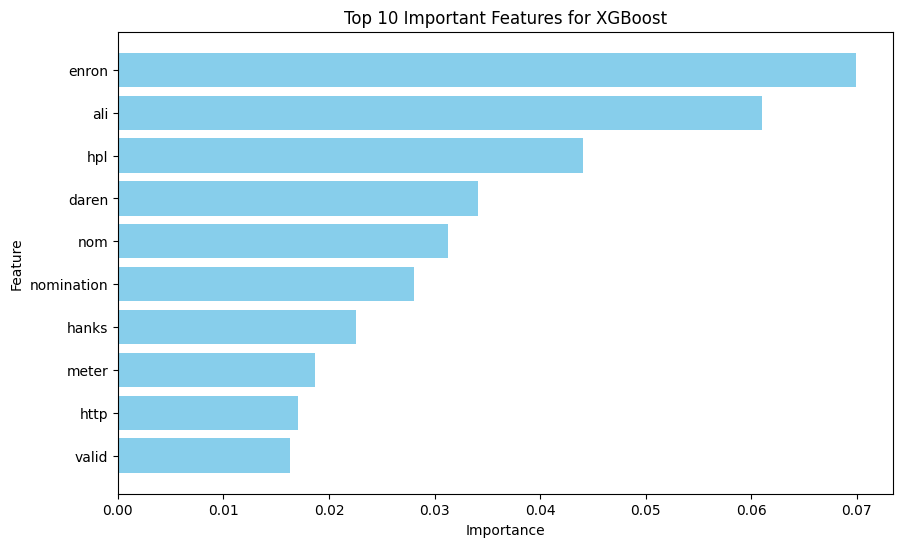

In [ ]:
# Feature importance analysis for XGBoost
xgb_feature_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_feature_importance
}).sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print("Top 10 Features for XGBoost:")
print(xgb_feature_importance_df.head(10))

# Visualize the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df['Feature'][:10], xgb_feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features for XGBoost')
plt.gca().invert_yaxis()
plt.show()

## XG Boost Model (PCA)

In [ ]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=10, random_state=42)  # Reduce to 10 components
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Initialize the XGBoost model
xgb_model_pca = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost model
xgb_model_pca.fit(x_train_pca, y_train)

# Make predictions using the XGBoost model
y_pred_xgb_pca = xgb_model_pca.predict(x_test_pca)

# Evaluate the model
print("XGBoost Accuracy with PCA:", accuracy_score(y_test, y_pred_xgb_pca))
xgbpca_accuracy = accuracy_score(y_test, y_pred_xgb_pca)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_pca))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:48:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy with PCA: 0.8473429951690822
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       735
           1       0.78      0.66      0.72       300

    accuracy                           0.85      1035
   macro avg       0.82      0.79      0.81      1035
weighted avg       0.84      0.85      0.84      1035



## XG Boost Model (TruncatedSVD)


In [ ]:
# Apply TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=10, random_state=42)  # Reduce to 10 components
x_train_svd = svd.fit_transform(x_train)
x_test_svd = svd.transform(x_test)

# Initialize the XGBoost model
xgb_model_svd = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost model
xgb_model_svd.fit(x_train_svd, y_train)

# Make predictions using the XGBoost model
y_pred_xgb_svd = xgb_model_svd.predict(x_test_svd)

# Evaluate the model
print("XGBoost Accuracy with SVD:", accuracy_score(y_test, y_pred_xgb_svd))
xgbsvd_accuracy = accuracy_score(y_test, y_pred_xgb_svd)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_svd))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:48:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy with SVD: 0.8570048309178744
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       735
           1       0.79      0.69      0.74       300

    accuracy                           0.86      1035
   macro avg       0.84      0.81      0.82      1035
weighted avg       0.85      0.86      0.85      1035



#**ACCURACIES**

##Accuracies with Normal Data

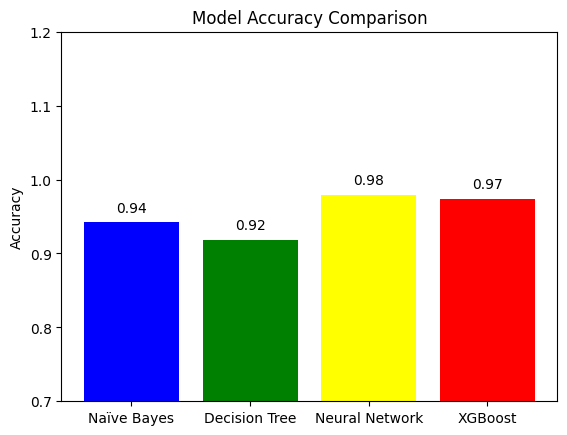

In [ ]:
models = ['Naïve Bayes', 'Decision Tree', 'Neural Network', 'XGBoost']
accuracies = [nb_accuracy, dt_accuracy, nn_accuracy, xgb_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'yellow', 'red'])
plt.ylim([0.70, 1.20])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')

plt.show()

## Accuracies with PCA

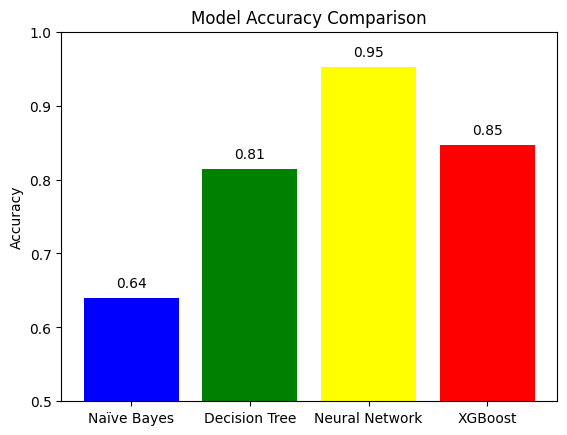

In [ ]:
models = ['Naïve Bayes', 'Decision Tree', 'Neural Network', 'XGBoost']
accuracies = [nbpca_accuracy, dtpca_accuracy, nnpca_accuracy, xgbpca_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'yellow', 'red'])
plt.ylim([0.50, 1])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')

plt.show()

## Accuracies with TruncatedSVG

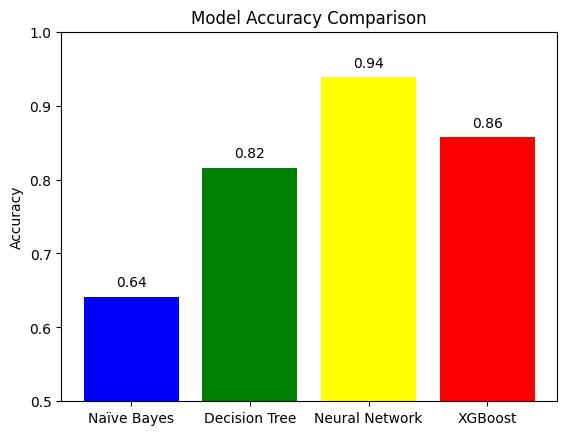

In [ ]:
models = ['Naïve Bayes', 'Decision Tree', 'Neural Network', 'XGBoost']
accuracies = [nbsvd_accuracy, dtsvd_accuracy, nnsvd_accuracy, xgbsvd_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'yellow', 'red'])
plt.ylim([0.50, 1])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')

plt.show()